# LocatNet

#### 0. Libraries

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from random import randrange
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### 1. Data import and manipulation

<ul>
  <li>image_size - desired feature dimensions.</li>
  <li>EPOCHS - number of epochs when training the CNN.</li>
  <li>MAX_IMAGES - amount of image samples.</li>
</ul>

In [4]:
image_size = (200, 200)
EPOCHS = 150
MAX_IMAGES = 12000
IMAGE_COUNT = 0                     # is set later

Preprocess data to feature and label space.

In [5]:
def load_images_and_labels(image_folder, country_counts, labels_df, max_images = IMAGE_COUNT):
    images = []
    labels = []

    excluded_images_count = 0

    for index, row in labels_df.iterrows():
        if len(images) >= max_images:
            break

        currentCountry = row['country']
        count = country_counts.loc[country_counts['country'] == currentCountry].values[0]

        if count[1] > 150:                              # make sure there are at least 20 samples of every label
            img_path = os.path.join(image_folder, str(row['ID']) + '.png')
            print(f"\rProcessing {str(row['ID'])}.png", flush=True, end='')

            img = cv2.imread(img_path)                  # load current image
            img = cv2.resize(img, image_size)           # resize
            img = img / 255.0                           # normalization

            images.append(img)
            labels.append(row['country'])
        else:                                       # skip low sample count labels
            excluded_images_count += 1
    
    print(f'\r{excluded_images_count} images were excluded due to low sample count.', flush=True)
    print(f'{len(images)} images were loaded.')
    return np.array(images), np.array(labels)       # sample + label array

Retrieve the data using the function.

In [6]:
image_folder = 'Data'
labels_df = pd.read_csv('coordinates_with_country.csv')
country_counts = pd.read_csv('country_counts.csv')

IMAGE_COUNT = labels_df.shape[0]                        # set the default image count

In [7]:
X, y = load_images_and_labels(image_folder, country_counts, labels_df, MAX_IMAGES)

1248 images were excluded due to low sample count.
12000 images were loaded.


In [8]:
def convert_to_uint8(image):
    # If the image is in float64 (CV_64F), we need to normalize and convert it to uint8
    if image.dtype == np.float64:
        image = (255 * (image - np.min(image)) / (np.max(image) - np.min(image))).astype(np.uint8)
    return image

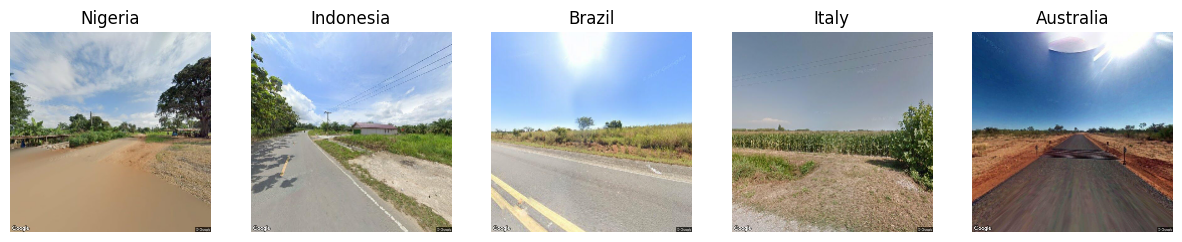

In [9]:
random_indices = random.sample(range(X.shape[0]), 5)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Iterate over the selected indices and plot each image
for i, idx in enumerate(random_indices):
    img = X[idx]
    img = convert_to_uint8(img)
    
    # Convert image from BGR (OpenCV default) to RGB for correct color display in matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    axs[i].imshow(img_rgb)
    axs[i].axis('off')  # Hide the axes

    axs[i].set_title(f'{y[idx]}', fontsize=12)

plt.show()

Encode the labels <span style="color:green"><b>(country names)</b></span> into numbers.

In [10]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Check dimensions of the data.

In [11]:
print(f"Number of samples: {X.shape[0]}")
print(f"Dimension of image samples: {X.shape[1:3]}")
print(f"Color channels in the image samples: {X.shape[3]}")

Number of samples: 12000
Dimension of image samples: (200, 200)
Color channels in the image samples: 3


Train-Test split.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

#### 2. Definition of the CNN

In [14]:
model = models.Sequential([
    layers.InputLayer(shape=(200, 200, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(y_encoded)), activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,886,315 (7.20 MB)

 Trainable params: 1,885,611 (7.19 MB)

 Non-trainable params: 704 (2.75 KB)

#### 3. Data augmentation <font color='#66FF07'><b>(Optional)</b></font>

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

#### 4. Training and Evaluation

Fitting the model

##### <font color='red'><b>WITHOUT</b></font> data augmentation

In [ ]:
history = model.fit(X_train, y_train, batch_size=32,
                    epochs=EPOCHS, validation_data=(X_test, y_test))

##### <font color='#66FF07'><b>WITH</b></font> data augmentation

In [17]:
# Verify GPU availability
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [18]:
# Ensure the model training runs on GPU
with tf.device('/GPU:0'):
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=EPOCHS,
                        validation_data=(X_val, y_val))

c:\Users\orddi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 149s 613ms/step - accuracy: 0.1661 - loss: 3.5712 - val_accuracy: 0.0896 - val_loss: 3.4539
Epoch 2/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 137s 570ms/step - accuracy: 0.2359 - loss: 2.8301 - val_accuracy: 0.2510 - val_loss: 2.7996
Epoch 3/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 134s 557ms/step - accuracy: 0.2647 - loss: 2.6386 - val_accuracy: 0.2354 - val_loss: 2.7671
Epoch 4/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 132s 549ms/step - accuracy: 0.2804 - loss: 2.5776 - val_accuracy: 0.2875 - val_loss: 2.5783
Epoch 5/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 136s 567ms/step - accuracy: 0.2880 - loss: 2.5305 - val_accuracy: 0.2828 - val_loss: 2.6607
Epoch 6/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 139s 577ms/step - accuracy: 0.3047 - loss: 2.4362 - val_accuracy: 0.1813 - val_loss: 3.0103
Epoch 7/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.3052 - loss: 2.4255

KeyboardInterrupt: 

#### 5. Testing

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

Accuracy and Loss to Epochs graphs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Saving the model

In [ ]:
model.save('models/locatNet.keras')

In [ ]:
model = load_model('models/locatNet.keras')

#### Issue a report on the model

In [22]:
def record_results(model, history, test_acc):
    insight_dir = "Reports"
    os.makedirs(insight_dir, exist_ok=True)

    hyperparams = {
        "image_size": image_size,
        "epochs": EPOCHS,
        "batch_size": 32,
        "max_images": MAX_IMAGES,
        "optimizer": "adam",
        "loss_function": "categorical_crossentropy",
    }

    run_name = f"{len(history.history['accuracy'])}Epochs_{hyperparams['max_images']}"
    run_dir = os.path.join(insight_dir, run_name)
    os.makedirs(run_dir, exist_ok=True)

    # Save hyperparameters to a text file
    with open(os.path.join(run_dir, "hyperparameters.txt"), "w", encoding='utf-8') as f:
        for key, value in hyperparams.items():
            f.write(f"{key}: {value}\n")

    # Save model summary
    with open(os.path.join(run_dir, "model_summary.txt"), "w", encoding='utf-8') as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))

    with open(os.path.join(run_dir, "model_results.txt"), "w", encoding='utf-8') as f:
        f.write(f"Test accuracy: {test_acc}\n\n")
        for index in range(len(history.history['accuracy'])):
            f.write(f"## Epoch {index + 1} ##\n")
            f.write(f"  Training accuracy: {history.history['accuracy'][index]:.4f}\n")
            f.write(f"      Training loss: {history.history['loss'][index]:.4f}\n")
            f.write(f"          Validation accuracy: {history.history['val_accuracy'][index]:.4f}\n")
            f.write(f"              Validation loss: {history.history['val_loss'][index]:.4f}\n\n")

    # Plot and save the training/validation accuracy and loss
    plt.figure(figsize=(8, 8))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Save plot to the run directory
    plot_path = os.path.join(run_dir, "training_validation_plot.png")
    plt.savefig(plot_path, dpi=300)  # Save the plot as an image with high resolution
    plt.close()  # Close the plot to free up memory
    
    print(f"Report created at {run_dir}")

In [ ]:
record_results(model, history, test_acc)

Visualization

In [19]:
def visualize_activations(model, image, layer_names, image_size):
    # Ensure the image is the correct shape for the model input
    img_resized = tf.image.resize(image, (image_size, image_size))
    img_resized = tf.expand_dims(img_resized, axis=0)  # Add batch dimension

    # Extract outputs of specified layers
    conv_layers = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=conv_layers)

    # Get activations
    activations = activation_model.predict(img_resized)

    # Plot each layer's activations
    for layer_name, activation in zip(layer_names, activations):
        n_filters = activation.shape[-1]  # Number of filters in the layer
        n_cols = int(np.sqrt(n_filters))  # Number of columns in the plot
        n_rows = int(np.ceil(n_filters / n_cols))  # Number of rows in the plot

        plt.figure(figsize=(15, 15))
        plt.suptitle(f"Activations in Layer: {layer_name}", fontsize=16)

        for i in range(n_filters):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(activation[0, :, :, i], cmap="viridis")  # First sample (batch index 0)

        plt.tight_layout()
        plt.show()

In [ ]:
random_index = random.sample(range(len(X_test)), 1)[0]
test_image = X_test[random_index]
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]
visualize_activations(model, test_image, conv_layers, 200)

In [ ]:
class PyDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Ensure the superclass constructor is called with **kwargs
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    # ...existing code...